# Import Statements

In [89]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# Import Snowflake modules
from snowflake.snowpark import Session
#from pyspark.sql.functions import year
import snowflake.snowpark.functions as F
# import snowflake.snowpark.types as T

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# DATA PREPARATION
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# MODEL BUILDING
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn. ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# MODEL EVALUATION & IMPROVEMENT
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# to export model
import joblib

# Functions

In [90]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [91]:
# Get account credentials from a json file
with open("StreamlitApp\data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "raw_pos",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [92]:
# retrieve order details usa table from snowflake
menu_table = session.table("frostbyte_tasty_bytes.raw_pos.MENU")
order_header = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_HEADER")
truck_table = session.table("frostbyte_tasty_bytes.raw_pos.TRUCK")

In [93]:
truck_table.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1           |1               |San Mateo       |California  |CA            |United States  |US                  |0                 |2009    |Ford_         |Step Van          |0          |1               |2019-01-01            |
|2           |2               |San Mateo       |California  |CA            |United State

In [94]:
# Get a list of TRUCK_IDs where the COUNTRY column's value is 'United States'
## Filter the 'location_table' where the 'COUNTRY' column is 'United States'
filtered_location_table = truck_table.filter(truck_table['COUNTRY'] == 'United States')

## Select the 'TRUCK_ID' column from the filtered DataFrame
truck_id_df = filtered_location_table.select('TRUCK_ID')

## Convert the 'LOCATION_ID' column to a Python list
location_id_list = truck_id_df.collect()

## Extract the values from the DataFrame and convert them to a list
location_id_list = [row['TRUCK_ID'] for row in location_id_list]

## Order Header table

In [95]:
order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|14271673    |90          |2666.0         |NULL           |NULL           |63645       |15:30:00            |22:30:00          |NULL             |2021-05-

In [96]:
# # Filter only for the United States
# order_header = order_header[order_header['ORDER_CURRENCY'] == 'USD']

In [97]:
# Filter only for the United States
order_header = order_header.filter(F.col("ORDER_CURRENCY") == "USD")

order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|14271673    |90          |2666.0         |NULL           |NULL           |63645       |15:30:00            |22:30:00          |NULL             |2021-05-

In [98]:

# List of unwanted columns
unwanted_columns = [
    "ORDER_ID", "SHIFT_ID", "SHIFT_START_TIME", "SHIFT_END_TIME", "ORDER_CHANNEL", "SERVED_TS",
    "E_MAIL", "PHONE_NUMBER", "ORDER_DETAIL_ID", "DISCOUNT_ID", "LINE_NUMBER", "QUANTITY", "UNIT_PRICE",
    "PRICE", "ORDER_ITEM_DISCOUNT_AMOUNT", "BIRTHDAY_DATE", "SIGN_UP_DATE", "CHILDREN_COUNT", "MARITAL_STATUS",
    "FAVOURITE_BRAND", "GENDER", "PREFERRED_LANGUAGE", "POSTAL_CODE", "COUNTRY", "FIRST_NAME",
    "MAX_ORDER_TS", "ORDER_DISCOUNT_AMOUNT", "ORDER_TAX_AMOUNT", "ORDER_AMOUNT", "ORDER_CURRENCY",
    "LAST_NAME", "MENU_ITEM_ID", "CUSTOMER_ID", "CITY"
]

# Drop the unwanted columns from the DataFrame
order_header = order_header.drop(unwanted_columns)

In [99]:
order_header.show()

--------------------------------------------------------------------
|"TRUCK_ID"  |"LOCATION_ID"  |"ORDER_TS"           |"ORDER_TOTAL"  |
--------------------------------------------------------------------
|271         |7714.0         |2022-07-18 20:33:16  |3.0000         |
|271         |7714.0         |2022-07-18 20:33:28  |15.5000        |
|271         |7714.0         |2022-07-18 20:34:01  |27.0000        |
|271         |7714.0         |2022-07-18 20:34:49  |15.0000        |
|271         |7714.0         |2022-07-18 20:36:06  |13.0000        |
|271         |7714.0         |2022-07-18 20:36:18  |45.5000        |
|271         |7714.0         |2022-07-18 20:37:18  |35.0000        |
|271         |7714.0         |2022-07-18 20:38:26  |19.0000        |
|271         |7714.0         |2022-07-18 20:38:58  |42.0000        |
|271         |7714.0         |2022-07-18 20:40:00  |43.5000        |
--------------------------------------------------------------------



In [100]:
# Convert the 'ORDER_TS' column to a java.sql.Timestamp object
order_header = order_header.withColumn('ORDER_TS', F.to_timestamp(order_header['ORDER_TS']))

# Extract the year from the 'ORDER_TS' column
order_header = order_header.withColumn('YEAR', F.year(order_header['ORDER_TS']))
order_header = order_header.withColumn('MONTH', F.month(order_header['ORDER_TS']))

# Drop the 'ORDER_TS' column
order_header = order_header.drop('ORDER_TS')

# Show the modified DataFrame with the 'YEAR' column
order_header.show()

-----------------------------------------------------------------
|"TRUCK_ID"  |"LOCATION_ID"  |"ORDER_TOTAL"  |"YEAR"  |"MONTH"  |
-----------------------------------------------------------------
|191         |11541.0        |80.0000        |2022    |4        |
|191         |11541.0        |82.0000        |2022    |4        |
|191         |11541.0        |41.0000        |2022    |4        |
|191         |11541.0        |12.0000        |2022    |4        |
|191         |11541.0        |55.0000        |2022    |4        |
|191         |11541.0        |12.0000        |2022    |4        |
|191         |11541.0        |26.0000        |2022    |4        |
|191         |11541.0        |14.0000        |2022    |4        |
|191         |11541.0        |69.0000        |2022    |4        |
|191         |11541.0        |38.0000        |2022    |4        |
-----------------------------------------------------------------



In [101]:
# View the unique years in the DataFrame
unique_years = order_header.select('YEAR').distinct().collect()
print("Unique years:")
for row in unique_years:
    print(row.YEAR)

Unique years:
2021
2019
2020
2022


In [102]:
# Group by 'YEAR' , 'MONTH' and 'TRUCK_ID' and calculate the sum of 'ORDER_TOTAL'
total_sales_by_truck = order_header.group_by(['YEAR', 'MONTH', 'TRUCK_ID']) \
                           .agg(F.sum(order_header['ORDER_TOTAL']).alias('TOTAL_SALES_PER_MONTH')) \
                           .orderBy(['YEAR', 'MONTH', 'TRUCK_ID'])

# View the data
total_sales_by_truck.show()

-----------------------------------------------------------
|"YEAR"  |"MONTH"  |"TRUCK_ID"  |"TOTAL_SALES_PER_MONTH"  |
-----------------------------------------------------------
|2019    |1        |1           |62520.0000               |
|2019    |1        |81          |733494.0000              |
|2019    |1        |97          |347133.0000              |
|2019    |1        |113         |1033498.0000             |
|2019    |1        |193         |932870.0000              |
|2019    |1        |224         |2700646.0000             |
|2019    |1        |257         |4128186.0000             |
|2019    |1        |392         |1842365.0000             |
|2019    |2        |1           |54220.0000               |
|2019    |2        |81          |672929.0000              |
-----------------------------------------------------------



In [103]:
# Use collect() to get a list of Row objects
truck_df_grp_by = total_sales_by_truck.collect()

# Convert the list of Row objects to a pandas DataFrame
total_sales_by_truck_df = pd.DataFrame(truck_df_grp_by)

In [104]:
# total_sales_by_truck_df.to_csv('StreamlitApp/assets/total_sales_by_truck.csv', index=False)

## Truck table

In [105]:
truck_table.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1           |1               |San Mateo       |California  |CA            |United States  |US                  |0                 |2009    |Ford_         |Step Van          |0          |1               |2019-01-01            |
|2           |2               |San Mateo       |California  |CA            |United State

In [106]:
# # Filter only for the United States
# truck_table = truck_table[truck_table['COUNTRY'] == 'United States']

In [107]:
# Filter only for the United States
truck_table = truck_table.filter(F.col("COUNTRY") == "United States")

truck_table.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1           |1               |San Mateo       |California  |CA            |United States  |US                  |0                 |2009    |Ford_         |Step Van          |0          |1               |2019-01-01            |
|2           |2               |San Mateo       |California  |CA            |United State

In [108]:
# List of unwanted columns
unwanted_columns = [
    "REGION", "ISO_REGION", "COUNTRY", "ISO_COUNTRY_CODE", "FRANCHISE_FLAG", "YEAR", "MAKE",
    "MODEL", "EV_FLAG", "FRANCHISE_ID", "TRUCK_OPENING_DATE", "MENU_TYPE_ID"
]

# Drop the unwanted columns from the DataFrame
truck_table = truck_table.drop(unwanted_columns)

In [109]:
# Display the modified DataFrame
truck_table.show()

-------------------------------
|"TRUCK_ID"  |"PRIMARY_CITY"  |
-------------------------------
|1           |San Mateo       |
|2           |San Mateo       |
|3           |San Mateo       |
|4           |San Mateo       |
|5           |San Mateo       |
|6           |San Mateo       |
|7           |San Mateo       |
|8           |San Mateo       |
|9           |San Mateo       |
|10          |San Mateo       |
-------------------------------



## Final table

In [110]:
# Merge the two tables using the 'TRUCK_ID' column as the common key
final_df = truck_table.join(total_sales_by_truck, on='TRUCK_ID', how='inner')

In [111]:
final_df.show()

----------------------------------------------------------------------------
|"TRUCK_ID"  |"PRIMARY_CITY"  |"YEAR"  |"MONTH"  |"TOTAL_SALES_PER_MONTH"  |
----------------------------------------------------------------------------
|73          |New York City   |2020    |1        |1637862.0000             |
|1           |San Mateo       |2020    |2        |28175.5000               |
|6           |San Mateo       |2020    |2        |30602.0000               |
|11          |San Mateo       |2020    |2        |60788.0000               |
|17          |Denver          |2020    |2        |377697.0000              |
|18          |Denver          |2020    |2        |340567.5000              |
|21          |Denver          |2020    |2        |184310.0000              |
|23          |Denver          |2020    |2        |369314.0000              |
|31          |Seattle         |2020    |2        |185170.0000              |
|33          |Seattle         |2020    |2        |372558.5000              |

In [112]:
total_sales_truck_city = final_df

In [113]:
# Use collect() to get a list of Row objects
truck_df_grp_by = total_sales_truck_city.collect()

# Convert the list of Row objects to a pandas DataFrame
total_sales_truck_city = pd.DataFrame(truck_df_grp_by)

In [114]:
# total_sales_truck_city.to_csv('StreamlitApp/assets/total_sales_by_truck_city.csv', index=False)

In [115]:
# View the unique city in the DataFrame
unique_years = final_df.select('PRIMARY_CITY').distinct().collect()
print("Unique city:")
for row in unique_years:
    print(row.PRIMARY_CITY)

Unique city:
New York City
San Mateo
Boston
Seattle
Denver


In [116]:
# Use collect() to get a list of Row objects
row_list = final_df.collect()

# Convert the list of Row objects to a pandas DataFrame
final_df = pd.DataFrame(row_list)

In [117]:
final_df.head()

,TRUCK_ID,PRIMARY_CITY,YEAR,MONTH,TOTAL_SALES_PER_MONTH
0,1,San Mateo,2019,1,62520.0000
1,1,San Mateo,2019,2,54220.0000
2,1,San Mateo,2019,3,61372.5000
3,1,San Mateo,2019,4,63564.0000
4,17,Denver,2019,4,492230.0000


In [118]:
# Convert 'TOTAL_SALES_PER_MONTH' column to numeric data type (decimal.Decimal to float)
final_df['TOTAL_SALES_PER_MONTH'] = final_df['TOTAL_SALES_PER_MONTH'].astype(float)

In [119]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_SALES_PER_MONTH'].min()
max_value = final_df['TOTAL_SALES_PER_MONTH'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 930.5 - 2781614.0


In [120]:
check = final_df.loc[final_df["MONTH"]==11]
check = check.loc[check["YEAR"]==2022]
check[["TRUCK_ID", "YEAR", "MONTH", "TOTAL_SALES_PER_MONTH"]].to_csv("StreamlitApp/assets/datasets/truck_last_month_sales.csv",index=False)

In [121]:
check.head()

,TRUCK_ID,PRIMARY_CITY,YEAR,MONTH,TOTAL_SALES_PER_MONTH
1569,1,San Mateo,2022,11,930.5
1570,2,San Mateo,2022,11,1177.0
1571,3,San Mateo,2022,11,1653.5
1572,4,San Mateo,2022,11,1752.0
1573,5,San Mateo,2022,11,2325.5


# Check for Missing Values

In [122]:
final_df.isnull().sum()

TRUCK_ID                 0
PRIMARY_CITY             0
YEAR                     0
MONTH                    0
TOTAL_SALES_PER_MONTH    0
dtype: int64

In [123]:
final_df.head()

,TRUCK_ID,PRIMARY_CITY,YEAR,MONTH,TOTAL_SALES_PER_MONTH
0,1,San Mateo,2019,1,62520.0
1,1,San Mateo,2019,2,54220.0
2,1,San Mateo,2019,3,61372.5
3,1,San Mateo,2019,4,63564.0
4,17,Denver,2019,4,492230.0


In [124]:
truck_total_sales_by_month = final_df
truck_total_sales_by_month.to_csv("StreamlitApp/assets/datasets/truck_total_sales_by_month.csv", index=False)

There are no missing values detected. Hence, no process required at this stage.

# Dealing with Outliers

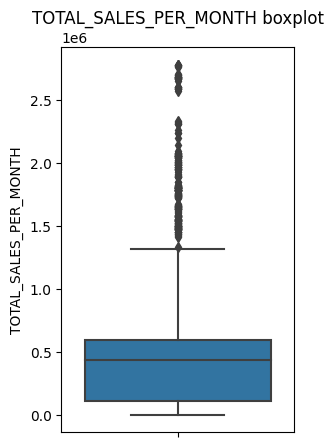

In [125]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_SALES_PER_MONTH'])
plt.title('TOTAL_SALES_PER_MONTH boxplot')
plt.show()

Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_SALES_PER_MONTH', axis=1), final_df['TOTAL_SALES_PER_MONTH'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((1150, 4), (494, 4))

# Categorical Variable Encoding 

In [127]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [128]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode
ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True)

In [129]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [130]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [131]:
# Save the model to a file
joblib.dump(scaler, "StreamlitApp/assets/truck_min_max_scaler.joblib")

['StreamlitApp/assets/truck_min_max_scaler.joblib']

## Standard Scaler

In [132]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [133]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [134]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Models

## Linear Regression

In [135]:
# LR = LinearRegression()
# LR.fit(X_train, y_train)

# y_fitted = LR.predict(X_train)
# print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # the lower the better
# print(LR.score(X_train, y_train), '(Train R^2 Value)') # higher better

In [136]:
# y_fitted2 = LR.predict(X_test)
# print(sqrt(mean_squared_error(y_fitted2, y_test)), '(Test RMSE)') # the lower the better
# print(LR.score(X_test, y_test), '(Test R^2 Value)') # higher better

## Decision Tree

In [137]:
# Create Decision Tree Regressor with random state equal to 0
# fit the model to the training data
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=0)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=0)

In [138]:
model_performance(tree_reg)

the training root mean squared error is:  790159.4892863737
the testing root mean squared error is:  803364.8686545981

the training mean squared error is:  624352018509.303
the testing mean squared error is:  645395112188.4198

training accuracy is:  -0.7152815693619254
testing accuracy is:  -0.7014728342423875


## MLP Regressor

In [139]:
# Create the MLP model, random state = 0
mlp = MLPRegressor(activation ='relu', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=0)
# Fit the model to the training set
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10,), max_iter=2000, random_state=0,
             solver='sgd')

In [140]:
model_performance(mlp)

the training root mean squared error is:  29419914351300.99
the testing root mean squared error is:  29419914356876.99

the training mean squared error is:  8.655313604378857e+26
the testing mean squared error is:  8.655313607659768e+26

training accuracy is:  -2377873293031945.5
testing accuracy is:  -2281824063610534.0


## ADA Boost Regressor

In [141]:
# Build Ada Boost Model 
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators = 20, learning_rate =0.1)
# fit the model to the training data
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, n_estimators=20)

In [142]:
model_performance(ada_reg)

the training root mean squared error is:  734696.1347921084
the testing root mean squared error is:  747859.974208396

the training mean squared error is:  539778410478.4639
the testing mean squared error is:  559294541022.9828

training accuracy is:  -0.482932595050767
testing accuracy is:  -0.47448353716823277


## XGBoost Regressor

In [143]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  151251.2011996801
the testing root mean squared error is:  159834.95305235975

the training mean squared error is:  22876925864.34611
the testing mean squared error is:  25547212217.250042

training accuracy is:  0.9371502483607533
testing accuracy is:  0.9326491837986124


# Model Improvement (GridSearch CV)

In [144]:
param_grid = {'n_estimators': [10, 20, 30, 40],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [3,4,5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

best_params = xgb_grid.best_params_
print("Best parameters found: ", best_params)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 40}
Best score found:  0.98424151156221


# Improved Model 

In [145]:
# Build XGBoost Model
xgb_improved = XGBRegressor(**best_params)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  36425.58532613487
the testing root mean squared error is:  56840.88903510373

the training mean squared error is:  1326823266.351532
the testing mean squared error is:  3230886666.300976

training accuracy is:  0.996354819994004
testing accuracy is:  0.9914823248744683


In [146]:
# Save the model to a file
joblib.dump(xgb_improved, "StreamlitApp/assets/models/truck_xgb_improved.joblib")

['StreamlitApp/assets/models/truck_xgb_improved.joblib']

In [147]:
xgb_improved.feature_importances_

array([0.70171845, 0.21933307, 0.04189551, 0.00167304, 0.        ,
       0.03537999, 0.        ], dtype=float32)

In [148]:
# Get the feature importances
feature_importance = xgb_improved.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                      Feature  Importance
0                    TRUCK_ID    0.701718
1                        YEAR    0.219333
2                       MONTH    0.041896
5         PRIMARY_CITY_Denver    0.035380
3        PRIMARY_CITY_Seattle    0.001673
4  PRIMARY_CITY_New York City    0.000000
6      PRIMARY_CITY_San Mateo    0.000000


In [149]:
X_train.head()

,TRUCK_ID,YEAR,MONTH,PRIMARY_CITY_Seattle,PRIMARY_CITY_New York City,PRIMARY_CITY_Denver,PRIMARY_CITY_San Mateo
114,33,2020,6,1,0,0,0
1258,65,2022,6,0,1,0,0
58,23,2020,2,0,0,1,0
1137,17,2022,5,0,0,1,0
1565,72,2022,10,0,1,0,0


In [150]:
X_train.columns

Index(['TRUCK_ID', 'YEAR', 'MONTH', 'PRIMARY_CITY_Seattle',
       'PRIMARY_CITY_New York City', 'PRIMARY_CITY_Denver',
       'PRIMARY_CITY_San Mateo'],
      dtype='object')